# This is the first script that needs to be run on Google Colab

In [ ]:
!pip install 'tensorflow-gpu==1.15.0'
!pip install PyDrive
!pip install pydicom
!pip install SimpleITK

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import warnings
warnings.filterwarnings('ignore')

class download_data_from_folder(object):
    def __init__(self,path):
        path_id = path[path.find('id=')+3:]
        self.file_list = self.get_files_in_location(path_id)
        self.unwrap_data(self.file_list)
    def get_files_in_location(self,folder_id):
        file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
        return file_list
    def unwrap_data(self,file_list,directory='.'):
        for i, file in enumerate(file_list):
            print(str((i + 1) / len(file_list) * 100) + '% done copying')
            if file['mimeType'].find('folder') != -1:
                if not os.path.exists(os.path.join(directory, file['title'])):
                    os.makedirs(os.path.join(directory, file['title']))
                print('Copying folder ' + os.path.join(directory, file['title']))
                self.unwrap_data(self.get_files_in_location(file['id']), os.path.join(directory, file['title']))
            else:
                if not os.path.exists(os.path.join(directory, file['title'])):
                    downloaded = drive.CreateFile({'id': file['id']})
                    downloaded.GetContentFile(os.path.join(directory, file['title']))
        return None

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
data_path = 'https://drive.google.com/open?id=1TSZ5tGhf1l0jbX55KZpUaF5S4RSa2xCy'
download_data_from_folder(data_path)

In [ ]:
import zipfile, os

def unzip(path_to_zip, out_path):
  with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
      zip_ref.extractall(out_path)
  return None

In [ ]:
path_to_data = os.path.join('.','Data.zip')
out_path = os.path.join('.')
unzip(path_to_data,out_path)

In [ ]:
os.chdir(os.path.join('.','Code'))

### Finished!

# DeepBox

## First we need to import a few things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Shape_Maker import Data_Generator, make_rectangle, make_circle
from Visualizing_Model.Visualing_Model import visualization_model_class

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
image_size = 64

## The make_rectangle and make_circle will both return circles and rectangles, and the Data_Generator will randomly create circles or rectangles

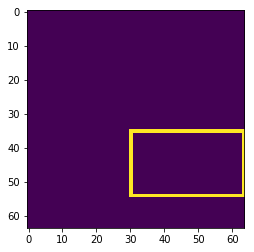

In [4]:
plt.imshow(make_rectangle(image_size))

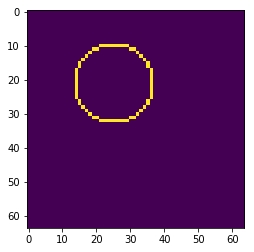

In [5]:
plt.imshow(make_circle(image_size))

## What do we need? We need a way to generate larges amounts of training data for our model..

### This is a 'generator', it is something which continously creates data

In [ ]:
train_generator = Data_Generator(image_size=image_size,batch_size=32, num_examples_per_epoch=100)

In [ ]:
x,y = train_generator.__getitem__(0)
print(x.shape)
print(y.shape)

## Now lets make our network!

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation
from keras.optimizers import Adam

In [ ]:
model = Sequential([
    Conv2D(1, (3,3), input_shape=(image_size, image_size, 1), padding='same',name='Conv_0'),
    MaxPool2D((image_size)), # Pool into a 1x1x6 image
    Flatten(),
    Dense(2),
    Activation('softmax')
])

In [ ]:
model.compile(Adam(lr=1e-1), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_generator,epochs=3)

In [ ]:
def determine_accuracy(model, image_size= 64, num_examples=1000):
    truth = np.zeros((num_examples,1))
    guess = np.zeros((num_examples,1))
    index = 0
    for _ in range(num_examples//2):
        pred = model.predict(make_rectangle(image_size)[None,...,None])
        guess[index] = np.argmax(pred)
        truth[index] = 1
        index += 1
    for _ in range(num_examples//2):
        pred = model.predict(make_circle(image_size)[None,...,None])
        guess[index] = np.argmax(pred)
        index += 1
    print('Accuracy is {} for {} examples'.format(str((guess==truth).sum()/num_examples),num_examples))

In [ ]:
determine_accuracy(model)

In [ ]:
rectangle = make_rectangle(image_size)[None,...,None]
circle = make_circle(image_size)[None,...,None]
print(model.predict(rectangle)[...,1]*100)
print(model.predict(circle)[...,0]*100)

## Lets see what the kernels and activations look like

In [ ]:
Visualizing_Class = visualization_model_class(model=model)

In [ ]:
Visualizing_Class.define_desired_layers(desired_layer_names=['Conv_0'])

## Kernels

In [ ]:
Visualizing_Class.plot_kernels()

## Activations
#### In order to make an activation map we need to provide it with something to predict on

In [ ]:
Visualizing_Class.predict_on_tensor(make_rectangle(image_size)[None,...,None])

In [ ]:
Visualizing_Class.plot_activations()

## How big is this model? Super tiny!!

In [ ]:
model.summary()

# Data curation

## Finding the Data

### Import some necessary functions

In [1]:
import os, pydicom
import numpy as np
import SimpleITK as sitk
from Distribute_Patients import Separate_files

### Find where we put our data

In [ ]:
print(os.listdir('..'))

In [5]:
data_path = os.path.join('..','Data','Whole_Patients')
print('We have ' + str(len(os.listdir(data_path))) + ' patients!')

We have 20 patients!


## Ensuring contour fidelity...

### Import some functions

This is our Dicom_Reader, we'll use it to handle our imaging and masks

In [2]:
from Dicom_RT_and_Images_to_Mask.Image_Array_And_Mask_From_Dicom_RT import DicomImagestoData, plot_scroll_Image

### What are the contour names we have?

Note that we've set 'get_images_mask' to False, this means we won't be getting any of the image data, just looking at the dicom RT files

In [ ]:
Dicom_Reader = DicomImagestoData(path=data_path,get_images_mask=False) # Set the get_images_mask to False so it will be fast

### View ROI names

#### This will tell us all the unique roi names, hence all_rois

In [ ]:
for roi in Dicom_Reader.all_rois:
    print(roi)

## Make contour associations

#### We have quite a few contour names here.. now, we can either change the ROI names in the RT files, or make an associations file

#### The associations file associates a contour name with another one {'Current contour':'Desired name'}

In [3]:
associations = {'Liver_BMA_Program_4':'Liver',
                'bma_liver':'Liver',
                'best_liver':'Liver',
                'tried_liver':'Liver'}

### Re-write RTs
#### This is commented out, because if I run it, then the example above won't show any different contour names

In [ ]:
# Dicom_Reader.associations = associations
# for RT in Dicom_Reader.all_RTs:
#     Dicom_Reader.rewrite_RT(RT)

## Pulling images and mask

### We'll first do this with one patient

In [6]:
patient_data_path = os.path.join(data_path,'ABD_LYMPH_036')
Dicom_Reader = DicomImagestoData(path=patient_data_path,get_images_mask=True,associations=associations)
print('Done!')

Done!


In [7]:
print(Dicom_Reader.rois_in_case)

['Liver_BMA_Program_4']


In [8]:
Dicom_Reader.get_mask(['Liver']) # Tell the class to load up the mask with contour name 'Liver'
print('Done')

Done


# View images

In [9]:
%matplotlib notebook

### The images and mask are saved within the Dicom_Reader class, so we just have to load them

In [10]:
Images = Dicom_Reader.ArrayDicom
mask = Dicom_Reader.mask # This is the mask

#### Threshold

In [11]:
Images[Images<-200] = -200
Images[Images>200] = 200

<IPython.core.display.Javascript object>


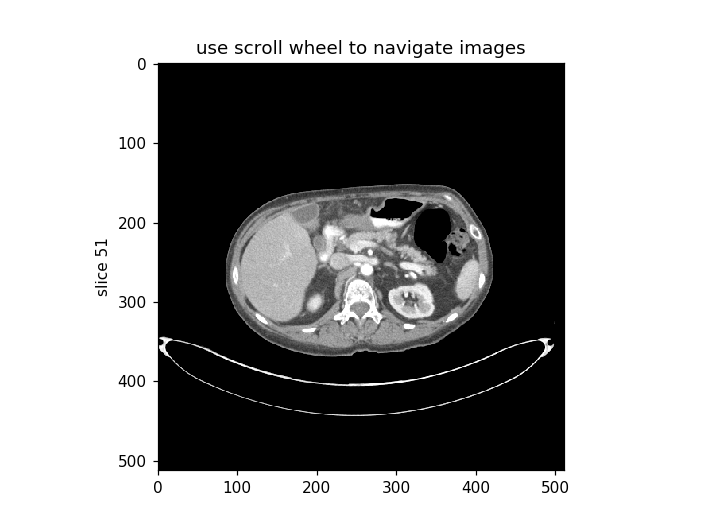

(<Figure size 640x480 with 1 Axes>,
 <Dicom_RT_and_Images_to_Mask.Image_Array_And_Mask_From_Dicom_RT.IndexTracker at 0x24e851152b0>)

In [12]:
plot_scroll_Image(Images)

In [ ]:
Images[mask==1] += 300

# Recap

## Checking ROI contour names and making associations

## Loading in image and mask from desired contour name

## Viewing images and mask

In [ ]:
def write_data(data_path, out_path, associations):
    for patient in os.listdir(data_path):
        print(patient)
        patient_data_path = os.path.join(data_path,patient)
        out_file = os.path.join(out_path,patient+'.txt')
        if not os.path.exists(out_file):
            Dicom_Reader = DicomImagestoData(path=patient_data_path,get_images_mask=True,associations=associations)
            image_handle = Dicom_Reader.dicom_handle
            Dicom_Reader.get_mask(['Liver']) # Tell the class to load up the mask with contour name 'Liver'
            mask_handle = Dicom_Reader.mask_handle
            num_images = image_handle.GetSize()[-1]
            for i in range(num_images):
                out_write_image = os.path.join(out_path, patient + '_' + str(i) + '_image.nii.gz')
                sitk.WriteImage(image_handle[:,:,i],out_write_image)
                sitk.WriteImage(mask_handle[:,:,i],out_write_image.replace('_image.','_annotation.'))
            fid = open(out_file,'w+')
            fid.close()
    return None

In [15]:
input_path = os.path.join('..','Data','Whole_Patients')
output_path = os.path.join('..','Data','Niftii_Arrays')
#write_data(input_path,output_path,associations=associations)

In [16]:
Separate_files(output_path) # Separate into a Training/Validation/Test set

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: '..\\Data\\Niftii_Arrays\\MED_LYMPH_024_36_annotation.nii.gz' -> '..\\Data\\Niftii_Arrays\\Train\\MED_LYMPH_024_36_annotation.nii.gz'

# Liver Model

## Import some things

In [1]:
from Liver_Generator import Data_Generator, os, plot_scroll_Image, dice_coef_3D
from Utils import ModelCheckpoint, TensorBoardImage, model_path_maker

c:\users\bmanderson\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\users\bmanderson\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
%matplotlib inline

In [4]:
%load_ext tensorboard

In [5]:
data_path = os.path.join('..','Data','Niftii_Arrays')
train_path = os.path.join(data_path,'Train')
validation_path = os.path.join(data_path,'Validation')
test_path = os.path.join(data_path,'Test')
model_path = os.path.join('..','Models')
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [6]:
args = {'batch_size':5,'on_vgg':True}#'mean_val':81,'std_val':31,
train_generator = Data_Generator(train_path, shuffle=True, **args) # mean_val=81,std_val=30

7.14% Done loading


KeyboardInterrupt: 

## Normalize images about the mask to be mean 0, std 1

In [ ]:
train_generator.get_mean_std_val() # This will calculate the mean and std for you and set it in the model
print(train_generator.mean_val)

In [ ]:
args_val = {'on_vgg':True,'mean_val':train_generator.mean_val,'std_val':train_generator.std_val,'by_patient':True,
       'shuffle':True}#'mean_val':81,'
validation_generator = Data_Generator(validation_path, **args_val)
test_generator = Data_Generator(test_path, **args_val)

In [ ]:
x,y = train_generator.__getitem__(0)

In [ ]:
plot_scroll_Image(x[...,-1])

In [ ]:
x,y = validation_generator.__getitem__(0)

### Alright, lets make our model!

In [ ]:
from Easy_VGG16_UNet.Keras_Fine_Tune_VGG_16_Liver import VGG_16
from Visualizing_Model.Visualing_Model import visualization_model_class
from keras.optimizers import Adam

In [ ]:
network = {'Layer_0': {'Encoding': [64, 64], 'Decoding': [32]},
           'Layer_1': {'Encoding': [128, 128], 'Decoding': [64]},
           'Layer_2': {'Encoding': [256, 256, 256], 'Decoding': [256]},
           'Layer_3': {'Encoding': [512, 512, 512], 'Decoding': [256]},
           'Layer_4': {'Encoding': [512, 512, 512]}}
VGG_model = VGG_16(network=network, activation='relu',filter_size=(3,3))
VGG_model.make_model()
VGG_model.load_weights()
new_model = VGG_model.created_model
model_path = os.path.join('..','Models')

## These are some tools for visualizing the model

In [ ]:
Visualizing_Class = visualization_model_class(model=new_model, save_images=True, verbose=True)

In [ ]:
Visualizing_Class.define_desired_layers(['block1_conv1','block1_conv1_activation','Output'])

In [ ]:
Visualizing_Class.predict_on_tensor(x[0,...][None,...])

In [ ]:
Visualizing_Class.plot_activations()

In [ ]:
new_model.compile(Adam(lr=5e-5),loss='categorical_crossentropy', metrics=['accuracy',dice_coef_3D])

### Freezing pre-trained layers

In [ ]:
def freeze_until_name(model,name):
    set_trainable = False
    for layer in model.layers:
        if layer.name == name:
            set_trainable = True
        layer.trainable = set_trainable
    return model
new_model = freeze_until_name(new_model,'Upsampling0_UNet')

### Now that our model is made, lets name it and make a checkpoint as it trains

A checkpoint is a way of assessing the model and determining if we should save it

In [ ]:
model_name = 'VGG_16_Model'
other_aspects = [model_name,'Upsampling0_UNet_Unfrozen'] # Just a list of defining things
model_path_out = model_path_maker(model_path,other_aspects)

In [ ]:
checkpoint = Model_Checkpoint(model_path_out, monitor='val_dice_coef_3D', verbose=1, save_best_only=True,
                              save_weights_only=False, period=5, mode='max')
# TensorboardImage lets us view the predictions of our model
tensorboard = TensorBoardImage(log_dir=model_path_out, batch_size=1, num_images=3,update_freq='epoch', 
                               data_generator=validation_generator)
callbacks = [checkpoint, tensorboard]

In [ ]:
%tensorboard --logdir {model_path}

In [ ]:
new_model.fit_generator(train_generator,epochs=5, workers=20, max_queue_size=50, validation_data=validation_generator,
                       callbacks=callbacks)

In [ ]:
x,y = validation_generator.__getitem__(0)

In [ ]:
pred = new_model.predict(x)

In [ ]:
pred[pred<0.5] = 0
pred[pred>0] = 1

In [ ]:
plot_scroll_Image(pred[...,1])